Take a look at:

* https://github.com/lzane/Fingers-Detection-using-OpenCV-and-Python
* https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
* https://github.com/tensorboy/pytorch_Realtime_Multi-Person_Pose_Estimation
* https://www.youtube.com/watch?v=zN49HdDxHi8
* 
* 
* 
* 


me: 131_

In [182]:
import os
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from skimage import io, transform

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20.0, 16.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
%matplotlib inline

import timeit, random
import json, cv2
import show

%load_ext autoreload
%autoreload 2

# Ignore warnings
# import warnings
# warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image
    
def rel_error(x, y):
  """ returns relative error """ 
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [3]:
# # Combine left and right joint annotations
# Joints = json.load(open("Dataset/annotation.json","r"))
# names = Joints.keys()
# json2 = {}
# for name in names:
#     if name[:-2] not in json2.keys():
#         json2[name[:-2]] = [0]*2
       
#     if name[-1] == 'L':
#         json2[name[:-2]][0] = Joints[name]
#     elif name[-1] == 'R':
#         json2[name[:-2]][1] = Joints[name]

# with open('combinedAnnotations.json', 'w') as outfile:
#     json.dump(data, outfile)

In [102]:
# Dataset class for memory efficient data processing 
class HandGestureDataset(torch.utils.data.Dataset):
    """ Hand Gesture Dataset """

    def __init__(self, root_dir, transform=False):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.joints = json.load(open(self.root_dir+"annotation.json","r"))
        self.names = self.joints.keys()
#         self.images =  ## Can't load all 12G worth of images
        self.transform = transform

    def __len__(self):
        return len(self.names)

    def __getitem__(self, idx):
        idx = np.random.randint(0, len(self.names))
        name = self.names[idx]
        
        image = cv2.imread("Dataset/Images/" + self.names[idx][:-2] + ".jpg")
        
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#         image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

        temp = []
        for i in xrange(len(self.joints[name])):
            temp.append([int(self.joints[name][i][0]), int(self.joints[name][i][1])])
            
        sample = {'image': image, 
                  'joints': temp,
                  'name' : name
                 }

        if self.transform:
            sample = self.hog(sample)

        return sample
    
    def substract_mean(self, sample):
        sample['image'] = sample['image'].astype(np.float64) - np.mean(sample['image'].astype(np.float64))
        return sample
    
    def hog(self, sample):
#         sample['image'] = cv2.Laplacian(sample['image'], cv2.CV_64F)
        sample['image'] = cv2.Sobel(sample['image'], cv2.CV_64F, 1, 0, ksize=5)
#         sample['image'] = cv2.Sobel(sample['image'], cv2.CV_64F, 0, 1, ksize=5)
        return sample
        

In [103]:
# DataLoader class to create a muli-process iterator and load data into memory faster
data = HandGestureDataset("Dataset/", transform=False)
dataloader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True, num_workers=2)

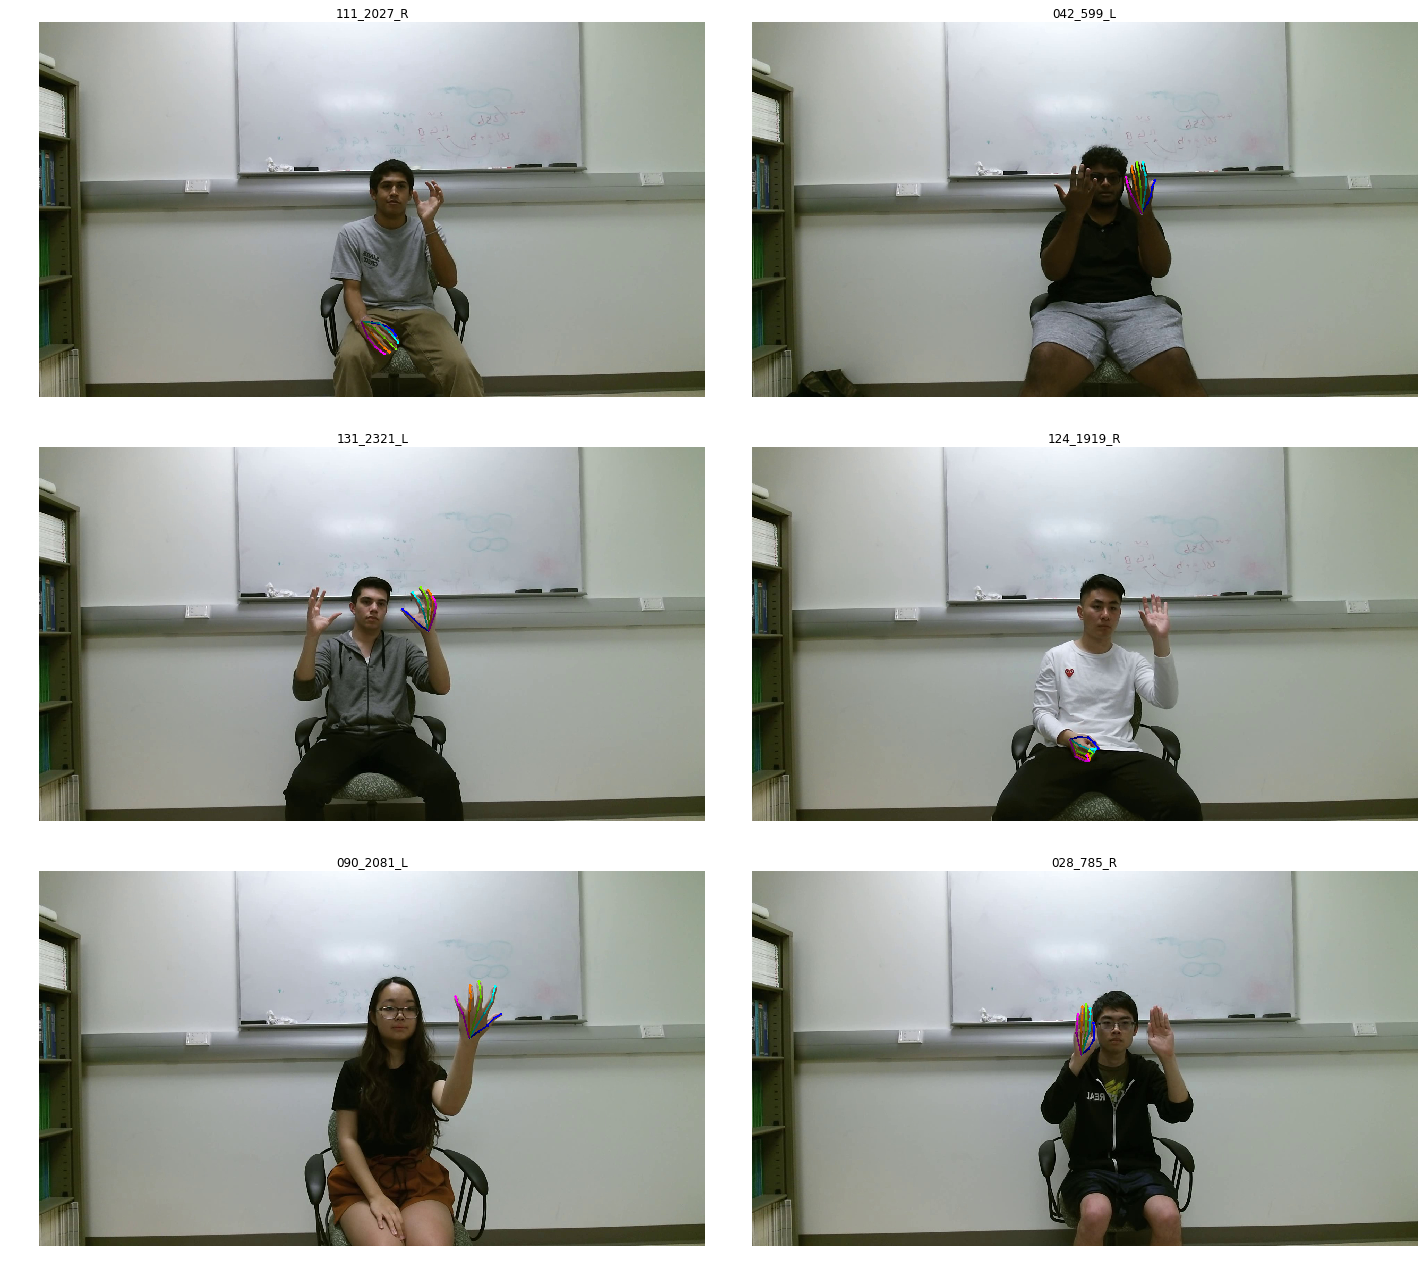

In [168]:
num = 6
fix, ax = plt.subplots(num//2, 2, figsize=(20, num*3))
ax = [a for b in ax for a in b] # wooooo


for i in range(len(data)):
    sample = data[i]
    
    plt.tight_layout()
    ax[i].set_title(sample['name'])
    ax[i].axis('off')
    
    
#     sample['image'] = cv2.cvtColor(sample['image'], cv2.COLOR_GRAY2RGB)
#     edges = cv2.Canny(sample['image'],100,200)
    
    canvas = show.draw_hand(sample['image'], sample['joints'])
    
#     ax[i].imshow(edges, cmap = 'gray')#[:,:,::-1])
    ax[i].imshow(canvas[:,:,::-1]) # image is bgr

    if i == num-1:
        plt.show()
        break

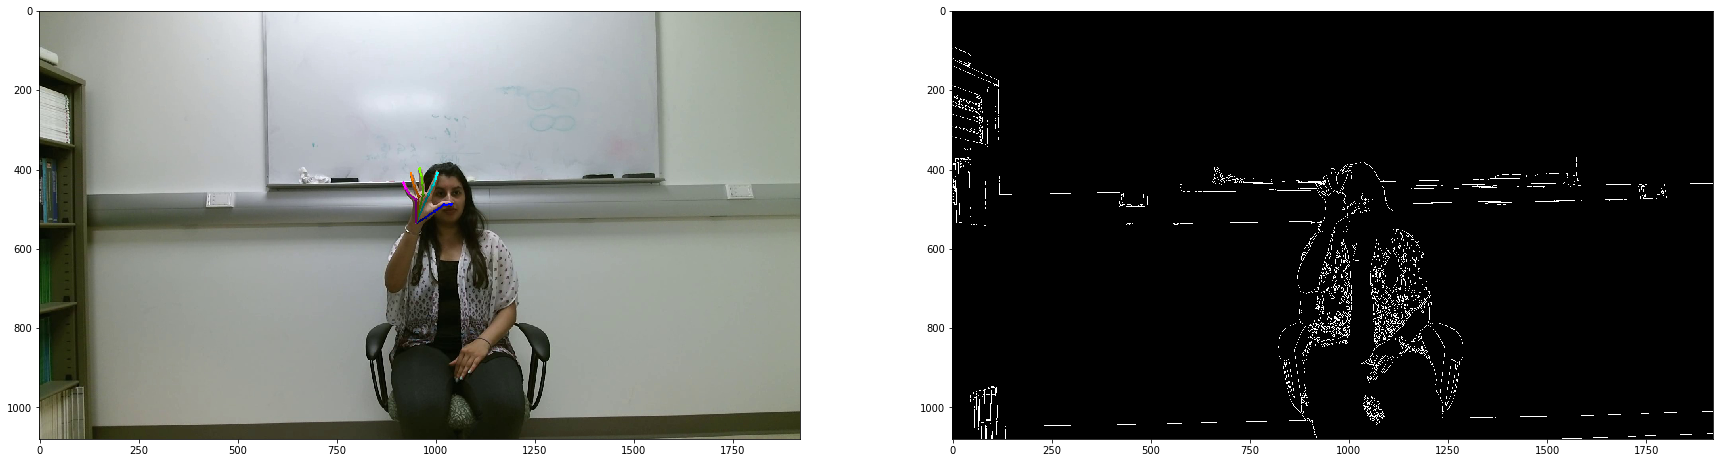

In [137]:
# shoft + tab = clutchhhhh
sample = data[i]
fig, ax = plt.subplots(1,2, figsize=(30, 20))
edges = cv2.Canny(sample['image'], 10, 300)
canvas = show.draw_hand(sample['image'], sample['joints'])
ax[0].imshow(sample['image'][:,:,::-1])
ax[1].imshow(edges, cmap = 'gray')
plt.show()

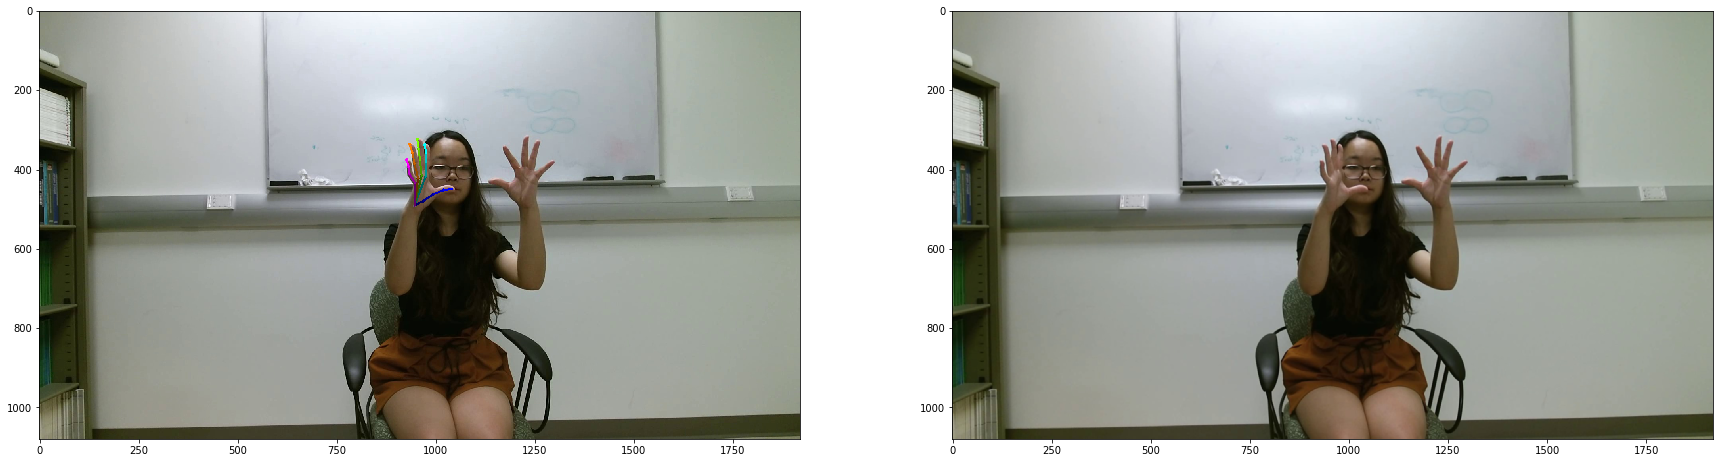

In [139]:
# Gaussian Blurring
sample = data[i]
fig, ax = plt.subplots(1,2, figsize=(30, 20))
blur = cv2.GaussianBlur(sample['image'], (5,5), 0)
canvas = show.draw_hand(sample['image'], sample['joints'])
ax[0].imshow(sample['image'][:,:,::-1])
ax[1].imshow(blur[:,:,::-1])
plt.show()

21 joints
shape (128, 128)


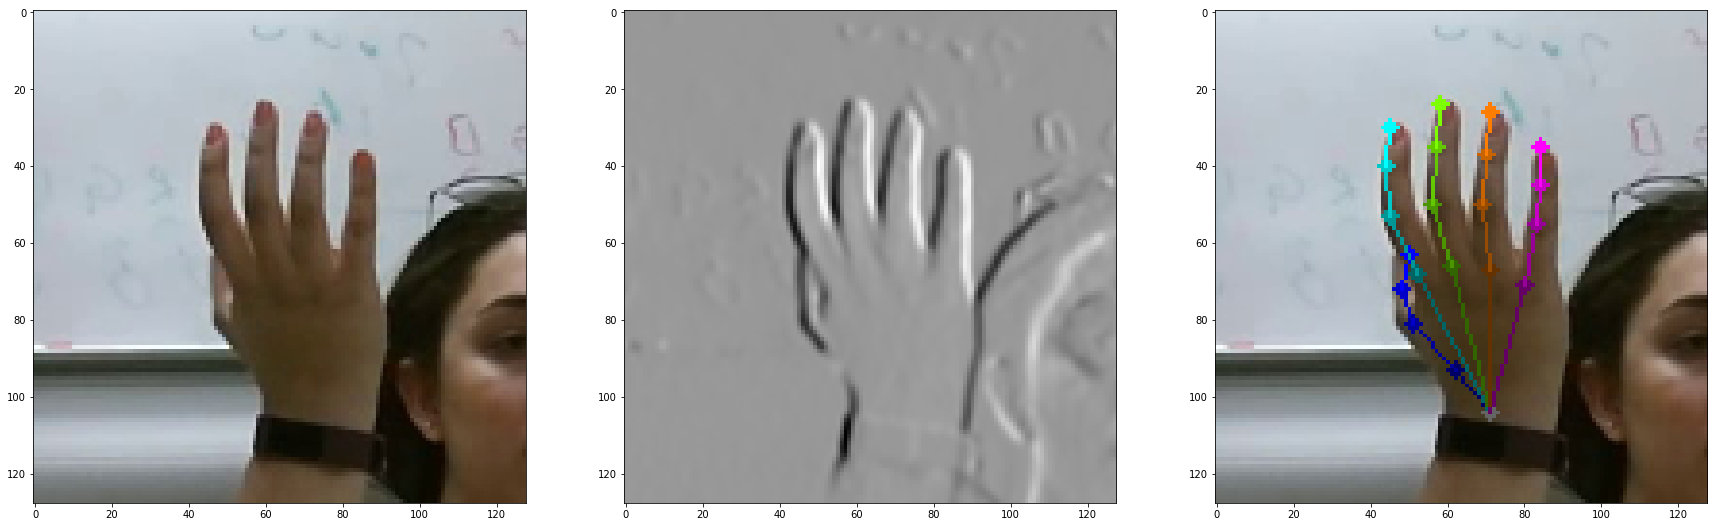

In [531]:
def transform_joint(joints):
    j_2 = []
    for J in joints:
        j_2.append([int(J[0]//2), int(J[1]//2)])
    return j_2

def center(joints):
    min_x = min(joints, key=lambda x : x[0])[0]
    max_x = max(joints, key=lambda x : x[0])[0]
    min_y = min(joints, key=lambda x : x[1])[1]
    max_y = max(joints, key=lambda x : x[1])[1]
    return (int((max_x-min_x)//2 + min_x), int((max_y-min_y)//2 + min_y))
        
        
    
            
sample = data[i]
fig, ax = plt.subplots(1,3, figsize=(30, 15))

small = cv2.resize(sample['image'], (0,0), fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA) # resize by half

gray = cv2.cvtColor(small, cv2.COLOR_BGR2GRAY)


j_2 = transform_joint(sample['joints'])
print len(j_2), 'joints'
_x, _y = center(j_2)
cropped = small[_y-64:_y+64 , _x-64:_x+64]
ax[0].imshow(cropped[:,:,::-1])


canvas = show.draw_hand(small, j_2)

gray_p = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)
gray_cropped = gray_p[_y-64:_y+64 , _x-64:_x+64]
ax[1].imshow(gray_cropped)
print 'shape', gray_cropped.shape


ax[2].imshow(cropped[:,:,::-1])
plt.savefig("processing.png")
plt.show()

In [497]:
joints = json.load(open("Dataset/annotation.json","r"))
names = joints.keys()

In [536]:
print len(names)

94126


In [548]:
unsaved = []
for i, name in enumerate(names):
    image = cv2.imread("Dataset/Images/" + name[:-2] + ".jpg")
    small = cv2.resize(image, (0,0), fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA) # resize by half
    gray = cv2.cvtColor(small, cv2.COLOR_BGR2GRAY)
    j_2 = transform_joint(joints[name])
    _x, _y = center(j_2)
    cropped = small[_y-64:_y+64 , _x-64:_x+64]

    gray_p = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)
    gray_cropped = gray_p[_y-64:_y+64 , _x-64:_x+64]
    
    u,v = gray_cropped.shape
    
    if u != 128:
        unsaved.append(name)
    elif v != 128:
        unsaved.append(name)
    else:
        cv2.imwrite('Dataset/ProcessedImages/' + name + '.png', gray_cropped)
#     print gray_cropped.shape
#     fig, ax = plt.subplots(1,1, figsize=(10, 10))
#     ax.imshow(gray_cropped)
#     plt.show()

print unsaved   

['090_71_L', '090_71_R', '065_401_R']
